#### **Imports**

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qulacs backend (**faster)

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics

In [2]:
import seaborn as sns

#### **Define the Energy Model**

In [3]:
# define the model
np.random.seed(610358)# should always be in the same cell!  
n_spins = 7

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')


            MODEL : my_model
Non-zero Interactions (J) : 21 / 21
Non-zero Bias (h) : 7 / 7
---------------------------------------------
Average Interaction Strength <|J|> :  0.6197959183673469
Average Bias Strength <|h|>:  0.31
alpha :  0.6364145068504942
---------------------------------------------


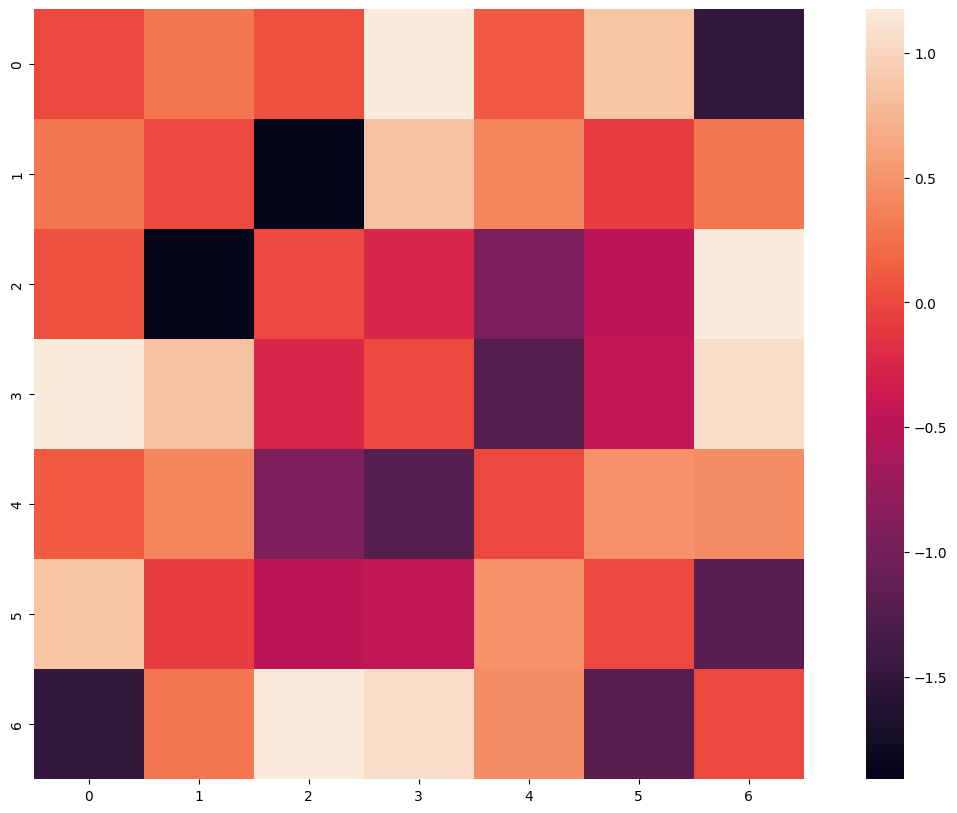

In [4]:
model.model_summary()

#### **Exact Analysis**

In [5]:
## set current beta
beta = 1.100209

## run exact sampling over all possible configurations 
esm = Exact_Sampling(model, beta)
esm.run_exact_sampling(beta)

     MODEL : my_model |  beta : 1.100209
Num Most Probable States : 4
Entropy : 1.5183894241385911
---------------------------------------------


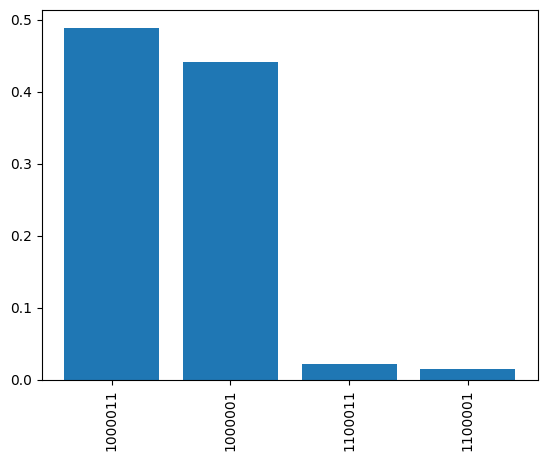

In [6]:
esm.sampling_summary()

#### **Run Classical MCMC**

In [21]:
steps = 100000
cl_chain =classical_mcmc(
    n_hops=steps,
    model=model,
    # return_last_n_states=10,
    temperature=1/beta,
)

In [22]:
cl_statistic = get_trajectory_statistics(cl_chain, esm, verbose= False)

<AxesSubplot: >

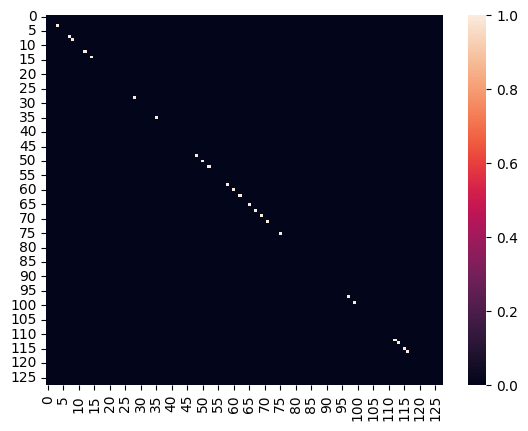

In [9]:
sns.heatmap(cl_statistic['transition_matrix'])

#### **Run Quantum Enhaned MCMC**

In [ ]:
steps = 100000
qamcmc_chain =quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta,
)

In [11]:
qumcm_statistic = get_trajectory_statistics(qamcmc_chain, esm, verbose= False)

<AxesSubplot: >

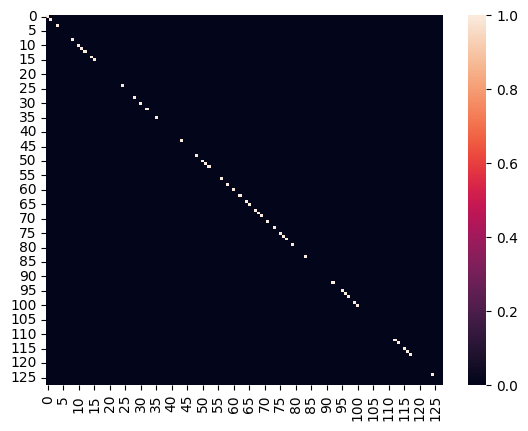

In [12]:
sns.heatmap(qumcm_statistic['transition_matrix'])

#### **Proposition Strategy Analysis**

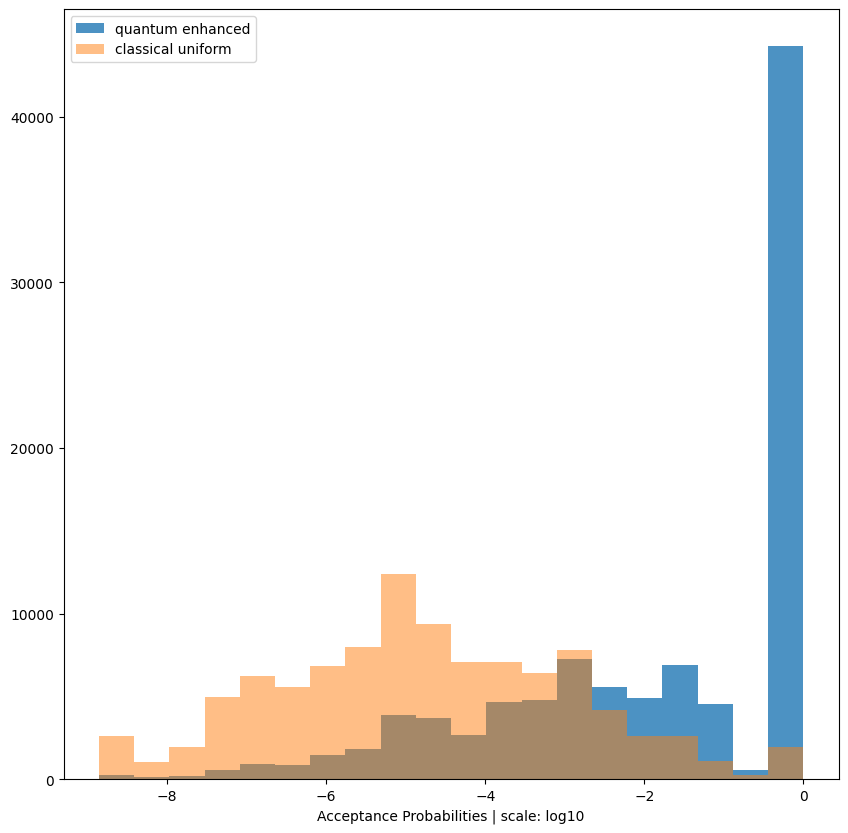

In [23]:
plt.figure(figsize=(10,10))

plt.hist(np.log10(qumcm_statistic['acceptance_prob']),label= 'quantum enhanced' , alpha= 0.8, bins= 20)
plt.hist(np.log10(cl_statistic['acceptance_prob']),label= 'classical uniform' ,alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

Transitions proposed by the "quantum-enhanced" algorithm are way more likely to be accepted.

#### **Convergence Analysis**

##### KL Divergence

In [25]:
kldiv_c = calculate_running_kl_divergence(esm.boltzmann_pd, cl_chain)
kldiv_q = calculate_running_kl_divergence(esm.boltzmann_pd, qamcmc_chain)

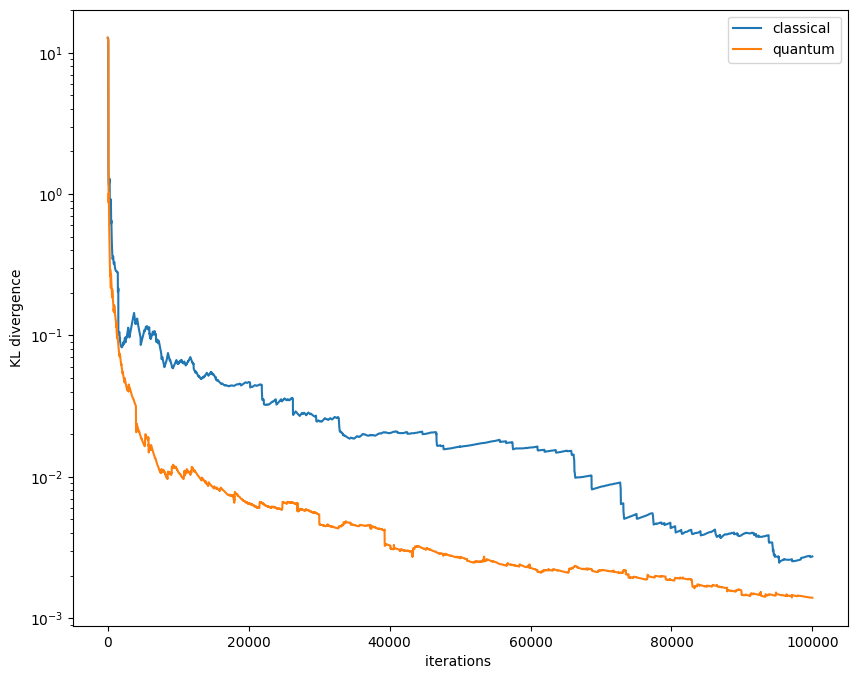

In [26]:
plt.figure(figsize=(10,8))
plt.plot(kldiv_c, label= 'classical')
plt.plot(kldiv_q, label= 'quantum')
plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()
